In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from zipfile import ZipFile

data_path = '/content/drive/MyDrive/Dataset/lung_and_colon_histopathological_images.zip'

with ZipFile(data_path,'r') as zip:
  zip.extractall()
  print('The data set has been extracted.')

The data set has been extracted.


In [4]:
path = '/content/lung_colon_image_set/lung_image_sets'
classes = os.listdir(path)
classes

['lung_n', 'lung_aca', 'lung_scc']

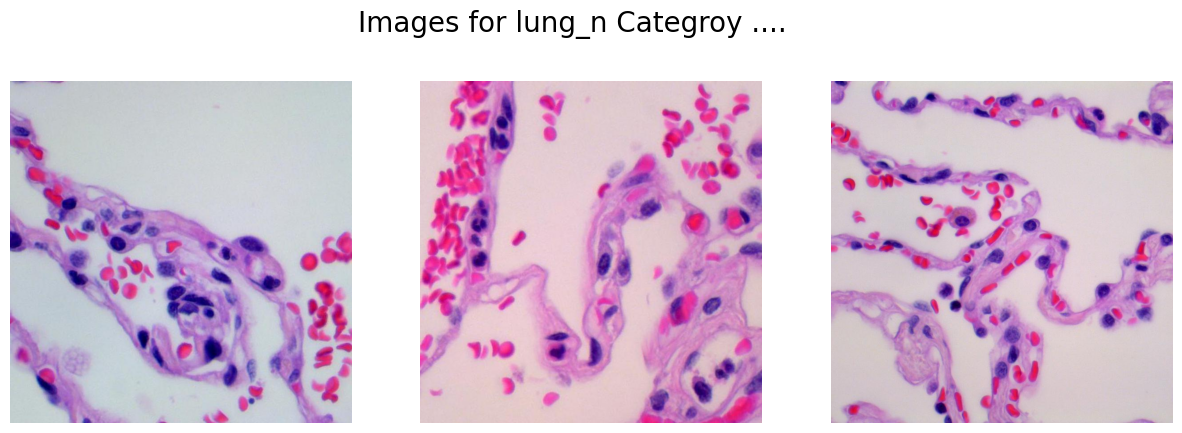

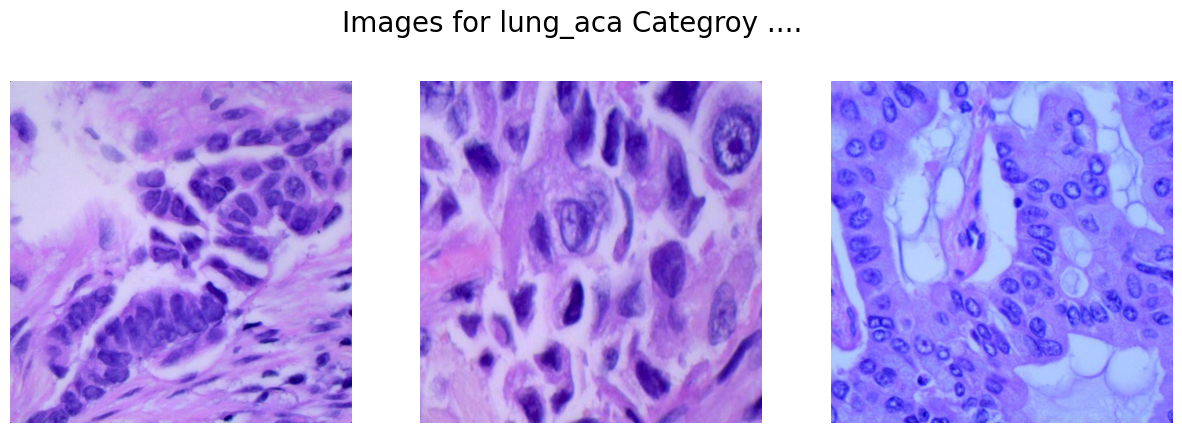

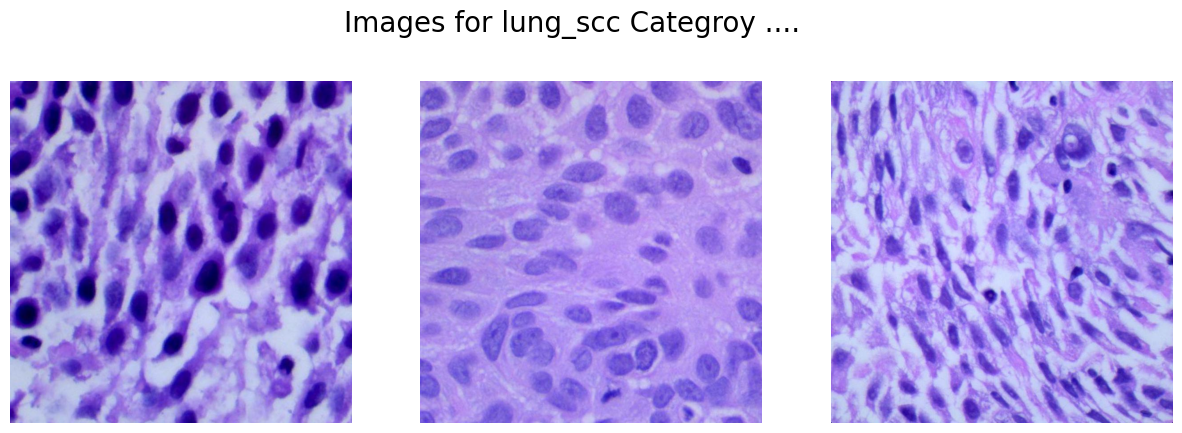

In [5]:
path = '/content/lung_colon_image_set/lung_image_sets'

for i in classes:
    image_dir = f'{path}/{i}'
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 3, figsize= (15,5))
    fig.suptitle(f'Images for {i} Categroy ....', fontsize=20)

    for j in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{i}/{images[k]}'))
        ax[j].imshow(img)
        ax[j].axis('off')
    plt.show()

In [6]:
IMG_SIZE = 128
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64

In [7]:
X = []
Y = []

for i, cat in enumerate(classes):
  images = glob(f'{path}/{cat}/*.jpeg')

  for image in images:
    img = cv2.imread(image)

    X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
    Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

In [8]:
X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y,
                                                  test_size = SPLIT,
                                                  random_state = 2022)
print(X_train.shape, X_val.shape)

(12000, 128, 128, 3) (3000, 128, 128, 3)


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE)
val_generator = val_datagen.flow(X_val, Y_val, batch_size=BATCH_SIZE)

In [11]:
base_model = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

In [12]:
model = keras.models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

In [13]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 256)               8388864   
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                        

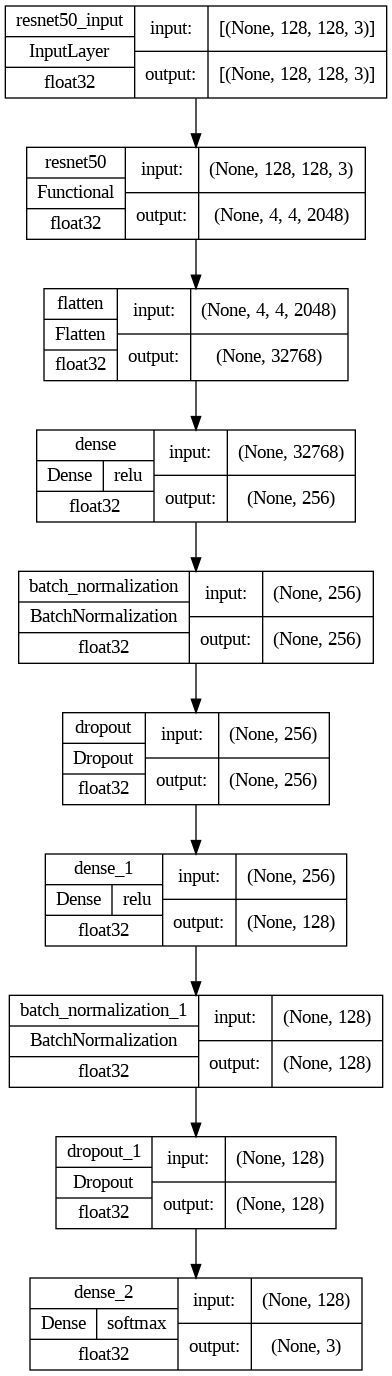

In [15]:
keras.utils.plot_model(model,
                       show_shapes= True,
                       show_dtype = True,
                       show_layer_activations=True)

In [16]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print('\n Validation accuracy has reached upto 90% so, stopping further training.')
            self.model.stop_training = True


es = EarlyStopping(patience=3,
                   monitor='val_accuracy',
                   restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss',
                       patience=2,
                       factor=0.5,
                       verbose=1)

In [17]:
history = model.fit(X_train, Y_train,
                    validation_data = (X_val, Y_val),
                    batch_size= BATCH_SIZE,
                    epochs = EPOCHS,
                    verbose =1,
                    callbacks = [es, lr, myCallback()])

Epoch 1/10
188/188 [==============================] - ETA: 0s - loss: 0.2150 - accuracy: 0.9187
 Validation accuracy has reached upto 90% so, stopping further training.
188/188 [==============================] - 29s 95ms/step - loss: 0.2150 - accuracy: 0.9187 - val_loss: 0.1010 - val_accuracy: 0.9600 - lr: 0.0010


In [18]:
Y_pred = model.predict(X_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)

94/94 [==============================] - 5s 39ms/step


In [19]:
print(metrics.classification_report(Y_val, Y_pred, target_names=classes))

              precision    recall  f1-score   support

      lung_n       1.00      1.00      1.00       987
    lung_aca       0.95      0.93      0.94       977
    lung_scc       0.93      0.95      0.94      1036

    accuracy                           0.96      3000
   macro avg       0.96      0.96      0.96      3000
weighted avg       0.96      0.96      0.96      3000



**Result : Overall Accuracy of 96% of all predictions are correct.**